<a href="https://colab.research.google.com/github/siddharthtelang/Face-Detection/blob/main/k_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
import random

In [2]:
from google.colab import files
uploaded = files.upload()

Saving pose.mat to pose.mat


In [26]:
# initialization
subjects = 68
types = 13
usePCA = True
useMDA = False
dataset_file = 'pose.mat'
# dataset_file = 'Data/data.mat'
# dataset_file = 'Data/illumination.mat'
dataset = ''

In [27]:
# load the dataset
data_ = sio.loadmat(dataset_file)

In [28]:
if 'pose' in dataset_file:
    data = data_.get('pose')
    dataset = 'pose'
elif 'illumination' in dataset_file:
    data = data_.get('illum')
    dataset = 'illum'
else:
    data = data_.get('face')
    dataset = 'face'

In [29]:
# flatten the dataset
if dataset == 'pose':
    flattened = np.zeros(shape=(subjects*types, data.shape[0]*data.shape[1]))
elif dataset == 'illum':
    flattened = np.zeros(shape=(subjects*types, data.shape[0]))
else:
    flattened = np.zeros(shape=(subjects*types, data.shape[0]*data.shape[1]))

c = 0
d = 0
for i in range(flattened.shape[0]):
    if c == types:
        c = 0
        d += 1
    if dataset == 'pose':
        temp = data[:,:,c,d]
        flattened[i] = temp.flatten()
    elif dataset == 'face':
        temp = data[:,:,i]
        flattened[i] = temp.flatten()
    elif dataset == 'illum':
        flattened[i] = data[:,c,d]
    c += 1


In [30]:
def doPCA(flattened, dim):
    pca = PCA(dim)
    projected = pca.fit_transform(flattened)
    return projected


Minimum dimensions required for 95% retention  199


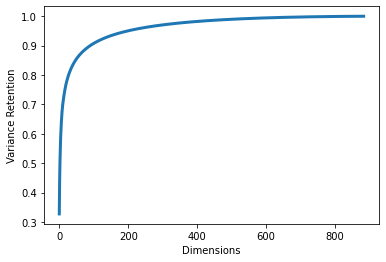

In [31]:
# Perform PCA if true
if usePCA:
    pca = PCA().fit(flattened)
    plt.figure()
    plt.xlabel('Dimensions')
    plt.ylabel('Variance Retention')
    plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
    min_dim = (np.where(pca.explained_variance_ratio_.cumsum() > 0.95))[0][0]
    print('Minimum dimensions required for 95% retention ', min_dim)
    projected = doPCA(flattened, min_dim)

In [32]:
print('Before dimension reduction shape = ', flattened.shape)
print('After dimension reduction shape = ', projected.shape)

Before dimension reduction shape =  (884, 1920)
After dimension reduction shape =  (884, 199)


In [33]:
# Split in training and testing data set
def genereate_training_testing_data(projected, subjects, types):
    training_data = []
    testing_data = []
    train_per_subject = int(math.ceil(2*types/3))
    test_per_subject = types - train_per_subject
    print('Training data per subject=', train_per_subject)
    print('Testing data per subject=', test_per_subject)

    for i in range(subjects):
        temp = []
        start = i*types
        end = (i+1)*types
        # print(start, start+train_per_subject)
        # print(start+train_per_subject, end)
        # print('-----------------')
        for j in range(start , start + test_per_subject):
            testing_data.append(projected[j])
        for j in range(start + test_per_subject , end):
            training_data.append(projected[j])
        # training_data.append(projected[start : start + train_per_subject])
        # testing_data.append(projected[start + train_per_subject : end])
    print('Size of training data = ', len(training_data))
    print('Size of testing data = ', len(testing_data))
    return training_data, testing_data, train_per_subject, test_per_subject



In [34]:
training_data, testing_data, train_per_subject, test_per_subject = genereate_training_testing_data(projected, subjects, types)

Training data per subject= 9
Testing data per subject= 4
Size of training data =  612
Size of testing data =  272


In [35]:
# Compute the mean and covariance for each training sample
def calculate_covariance_mean(training_data, dataset):
    cov = []
    mu = []
    for i in range(len(training_data)):
        sample = training_data[i]
        size = sample.shape[0]
        sample = sample.reshape(1, size)
        cov_ = np.dot((sample - np.mean(sample)).T, (sample - np.mean(sample))) / size
        # add noise to make determinant non-zero
        if dataset == 'face':
            noise = 0.24*np.identity(cov_.shape[0])
        elif dataset == 'pose':
            noise = 0.03*np.identity(cov_.shape[0])
        else:
            noise = 0.01*np.identity(cov_.shape[0])
        cov_ = cov_ + noise
        mu.append(np.mean(sample))
        cov.append(cov_)
    return cov, mu

In [36]:
cov, mu = calculate_covariance_mean(training_data, dataset)

In [37]:
np.linalg.det(cov[0])

5.040493342608535e-298

In [40]:
# K-NN
k = 1
while (k<=8):
  score = 0
  actual_tests = len(testing_data)
  for i in range(len(testing_data)):
      test_class = int(i/test_per_subject)
      dist = np.zeros(shape=(len(training_data)))
      for j in range(len(training_data)):
          d =  np.dot(testing_data[i] - mu[j], np.dot(np.linalg.inv(cov[j]), (testing_data[i] - mu[j]).T))
          # d = np.linalg.norm(testing_data[i] - training_data[j])
          dist[j] = d
      
      sort = np.argsort(dist)
      
      predicted_nearest_class = np.zeros(shape=dist.shape[0])
      votes_class = np.zeros(shape=subjects)

      for l in range(k):
          predicted_nearest_class[l] = int(sort[l]/train_per_subject)
          temp_class = int(predicted_nearest_class[l])
          # print(temp_class)
          votes_class[temp_class] += 1
      
      # print(sort[:k])
      # print(votes_class)
      
      # print(np.where(votes_class == np.max(votes_class)))
      same_votes = (np.where(votes_class == np.max(votes_class)))[0]
      if len(same_votes) > 1:
          # print('Same votes, skip this sample')
          actual_tests -= 1
          continue

      votes_class = -1*votes_class
      predicted_class = np.argsort(votes_class)[0]

      # print(predicted_class)
      # print(test_class)

      if predicted_class == test_class:
          score += 1
          # print('Correct, score = ', score)
      # else:
          # print('Incorrect')
      # print('-------------------------------------------')
      
  print('Accuracy of ',str(k),'-NN = ', (score*100/actual_tests))
  k += 1

Accuracy of  1 -NN =  92.6470588235294
Accuracy of  2 -NN =  97.43589743589743
Accuracy of  3 -NN =  94.52054794520548
Accuracy of  4 -NN =  88.88888888888889
Accuracy of  5 -NN =  85.13513513513513
Accuracy of  6 -NN =  82.87671232876713
Accuracy of  7 -NN =  79.72972972972973
Accuracy of  8 -NN =  75.64102564102564


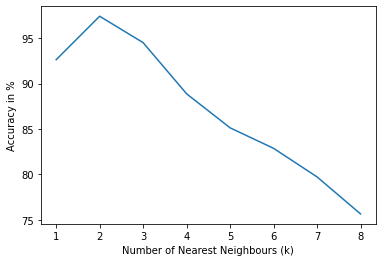

In [41]:
accuracy = [92.64, 97.43, 94.52, 88.88, 85.13, 82.87, 79.72, 75.64]
neighbours = [1,2,3,4,5,6,7,8]
plt.xlabel('Number of Nearest Neighbours (k)')
plt.ylabel('Accuracy in %')
plt.plot(neighbours, accuracy)